# RACE Dataset Analysis - Updated Setup

This notebook has been updated to download the RACE dataset directly using the Hugging Face datasets library. The following changes were made:

1. Fixed NLTK resource naming (`punkt_tab` → `punkt`)
2. Added direct dataset loading from Hugging Face instead of local files
3. Ensured all required dependencies are installed

## Requirements

Before running this notebook, make sure you have the following packages installed:
- pandas
- matplotlib
- seaborn
- nltk
- scikit-learn
- pyarrow
- gensim
- torch (PyTorch)
- transformers
- datasets

You can install them using pip:
```
pip install pandas matplotlib seaborn nltk scikit-learn pyarrow gensim torch transformers datasets
```

## Notes on Dataset

The RACE dataset will be automatically downloaded when you run the data loading cell. The download is approximately 250MB, so ensure you have a stable internet connection.

# RACE Dataset Analysis - Natural Language Processing Group Assignment

**Group Members:**
- [Student 1 Name]
- [Student 2 Name]
- [Student 3 Name]
- [Student 4 Name]
- [Student 5 Name] (if applicable)

**Video Presentation Link:** [Insert link here when ready]

## Introduction

This notebook analyzes the RACE (ReAding Comprehension dataset from Examinations) dataset, a large-scale reading comprehension dataset with over 28,000 passages and nearly 100,000 questions collected from English examinations in China for middle and high school students. We will perform various NLP tasks on this dataset, following the assignment requirements.

## Setup and Imports

Let's start by importing the necessary libraries for our analysis.

In [1]:
# Installation of required packages (if missing)
# Uncomment and run this cell if you're missing any dependencies

import sys
import subprocess

def install_if_missing(package):
    try:
        __import__(package)
        print(f"✅ {package} is already installed")
    except ImportError:
        print(f"📥 Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✅ {package} has been installed")

# Install key packages
# install_if_missing("pandas")
# install_if_missing("matplotlib")
# install_if_missing("seaborn")
# install_if_missing("nltk")
# install_if_missing("scikit-learn")
# install_if_missing("pyarrow")
# install_if_missing("gensim")
# install_if_missing("torch")
# install_if_missing("transformers")
# install_if_missing("datasets")

In [2]:
# Basic data processing and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import Counter
import re
import os
import json
import pyarrow.parquet as pq

# Text processing libraries
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Machine learning libraries
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.cluster import KMeans

# For dimensionality reduction and visualization
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Configure visualizations
plt.style.use('ggplot')
sns.set_style('whitegrid')

# Download NLTK resources if needed
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Estudios\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1. Preliminary Analysis

### 1.1 Dataset Structure and Description

The RACE dataset is a large-scale reading comprehension dataset with over 28,000 passages and nearly 100,000 questions. The dataset is collected from English examinations in China for middle and high school students.

Let's first explore the structure of the dataset.

In [3]:
# Import datasets library
from datasets import load_dataset

# Download and load the RACE dataset from Hugging Face
print("Downloading and loading the RACE dataset...")
dataset = load_dataset("race", "all")

# Convert the datasets to pandas DataFrames
train_data = dataset['train'].to_pandas()
val_data = dataset['validation'].to_pandas()
test_data = dataset['test'].to_pandas()

# Display the basic information about the dataset
print(f"Train set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")
print("\nSample data point:")
display(train_data.iloc[0])

# Check the dataset structure
print("\nDataset columns:")
print(train_data.columns)

c:\Users\Estudios\Documents\VC_Projects\12vo_Semestre\NLP\nlp_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Train set size: 87866
Validation set size: 4887
Test set size: 4934

Sample data point:
Train set size: 87866
Validation set size: 4887
Test set size: 4934

Sample data point:


example_id                                        high19088.txt
article       Last week I talked with some of my students ab...
answer                                                        C
question      We can know from the passage that the author w...
options                      [doctor, model, teacher, reporter]
Name: 0, dtype: object


Dataset columns:
Index(['example_id', 'article', 'answer', 'question', 'options'], dtype='object')


Article length statistics:
count    87866.000000
mean      1559.996791
std        577.182668
min          9.000000
25%       1199.000000
50%       1590.000000
75%       1882.000000
max       6437.000000
Name: article_length, dtype: float64

Question length statistics:
count    87866.000000
mean        52.628343
std         18.932038
min          1.000000
25%         39.000000
50%         50.000000
75%         63.000000
max        380.000000
Name: question_length, dtype: float64

Options count statistics:
count    87866.0
mean         4.0
std          0.0
min          4.0
25%          4.0
50%          4.0
75%          4.0
max          4.0
Name: options_count, dtype: float64


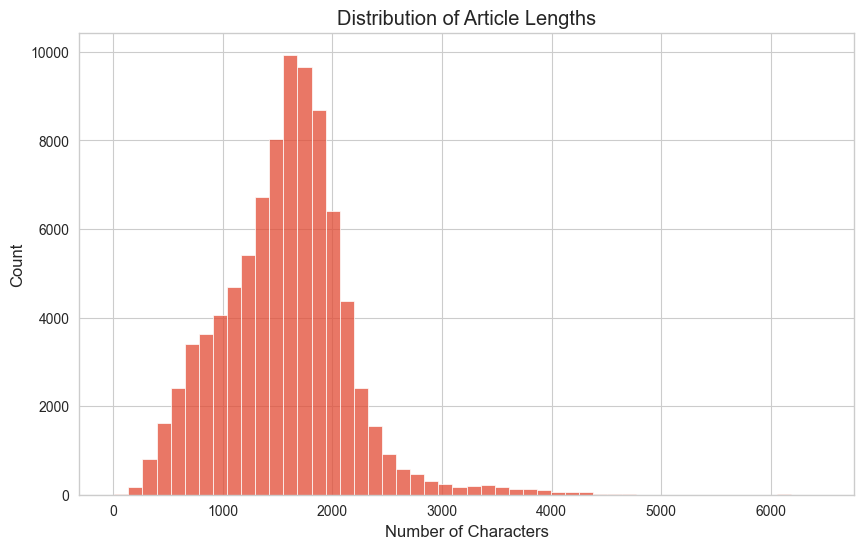

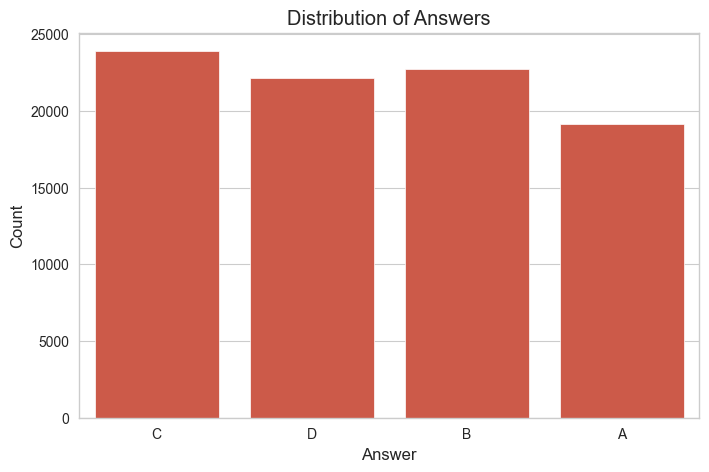

In [4]:
# Basic statistics about the articles
train_data['article_length'] = train_data['article'].apply(len)
train_data['question_length'] = train_data['question'].apply(len)
train_data['options_count'] = train_data['options'].apply(len)

# Summary statistics
print("Article length statistics:")
print(train_data['article_length'].describe())

print("\nQuestion length statistics:")
print(train_data['question_length'].describe())

print("\nOptions count statistics:")
print(train_data['options_count'].describe())

# Visualize the distribution of article lengths
plt.figure(figsize=(10, 6))
sns.histplot(train_data['article_length'], bins=50)
plt.title('Distribution of Article Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Count')
plt.show()

# Distribution of answers
plt.figure(figsize=(8, 5))
sns.countplot(data=train_data, x='answer')
plt.title('Distribution of Answers')
plt.xlabel('Answer')
plt.ylabel('Count')
plt.show()

### 1.2 Vocabulary Analysis

Now, let's analyze the vocabulary of the dataset to understand its richness and diversity.

In [5]:
# Function to tokenize and preprocess text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

# Sample a portion of the dataset for vocabulary analysis (to avoid memory issues)
sample_size = min(5000, len(train_data))
sampled_data = train_data.sample(sample_size, random_state=42)

# Tokenize articles
print("Tokenizing articles...")
sampled_data['tokens'] = sampled_data['article'].apply(preprocess_text)

# Calculate vocabulary size
all_tokens = [token for tokens_list in sampled_data['tokens'] for token in tokens_list]
unique_tokens = set(all_tokens)
vocab_size = len(unique_tokens)

# Calculate average document vocabulary size
sampled_data['doc_vocab_size'] = sampled_data['tokens'].apply(lambda x: len(set(x)))
avg_doc_vocab = sampled_data['doc_vocab_size'].mean()

print(f"Total vocabulary size (from sample): {vocab_size}")
print(f"Average document vocabulary size: {avg_doc_vocab:.2f}")

# Plot document vocabulary size distribution
plt.figure(figsize=(10, 6))
sns.histplot(sampled_data['doc_vocab_size'], bins=30)
plt.title('Distribution of Document Vocabulary Size')
plt.xlabel('Number of Unique Words')
plt.ylabel('Count')
plt.show()

# Most common words
word_freq = Counter(all_tokens)
most_common_words = word_freq.most_common(20)

plt.figure(figsize=(12, 6))
words, counts = zip(*most_common_words)
sns.barplot(x=list(words), y=list(counts))
plt.title('Most Common Words')
plt.xlabel('Word')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Tokenizing articles...


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - 'C:\\Users\\Estudios/nltk_data'
    - 'c:\\Users\\Estudios\\Documents\\VC_Projects\\12vo_Semestre\\NLP\\nlp_venv\\nltk_data'
    - 'c:\\Users\\Estudios\\Documents\\VC_Projects\\12vo_Semestre\\NLP\\nlp_venv\\share\\nltk_data'
    - 'c:\\Users\\Estudios\\Documents\\VC_Projects\\12vo_Semestre\\NLP\\nlp_venv\\lib\\nltk_data'
    - 'C:\\Users\\Estudios\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


### 1.3 Document Clustering

Let's cluster the articles to see if we can identify different types or topics of passages.

Vectorizing documents...
Applying PCA...
Applying PCA...
Applying t-SNE...
Applying t-SNE...


c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Performing K-means clustering...


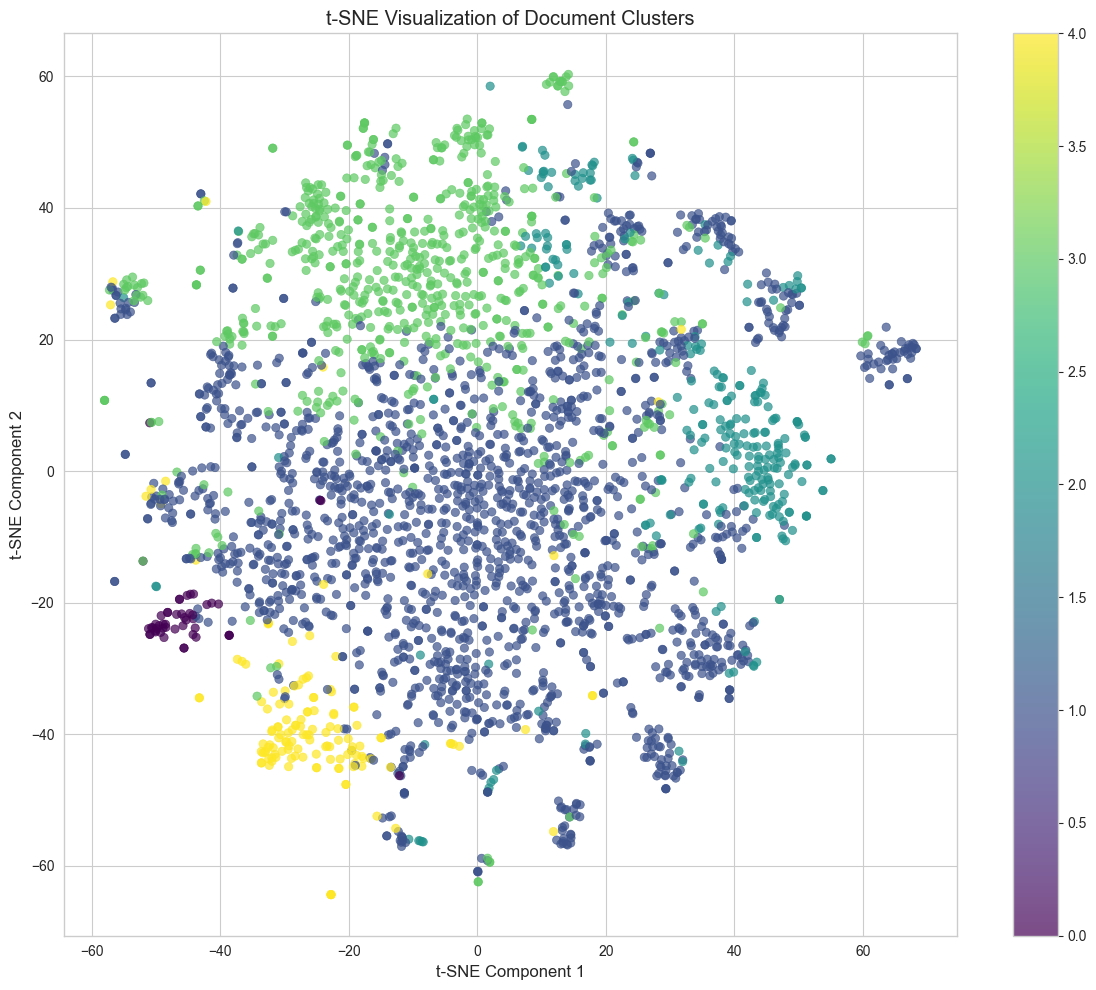

Cluster 0 top terms: 100, 12, 00p, 120, 130, 150, 16, 17, 110, 18th
Cluster 1 top terms: 10, 11, 13, 100, 1950s, 1990, 00a, 18, 1986, 1954
Cluster 2 top terms: 00, 00p, 100, 110, 15, 14, 000, 1982, 1974, 1st
Cluster 3 top terms: 000, 110, 12, 1960s, 130, 17, 1999, 19th, 1970, 1963
Cluster 4 top terms: 00p, 00a, 130, 19, 1913, 18th, 1995, 1994, 12, 1997


In [ ]:
# Use TF-IDF vectorization for clustering
print("Vectorizing documents...")
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
sample_size_for_clustering = min(3000, len(train_data))  # Adjust based on computational resources
cluster_sample = train_data.sample(sample_size_for_clustering, random_state=42)
tfidf_matrix = tfidf_vectorizer.fit_transform(cluster_sample['article'])

# Apply dimensionality reduction for visualization
print("Applying PCA...")
pca = PCA(n_components=50, random_state=42)
reduced_features = pca.fit_transform(tfidf_matrix.toarray())

print("Applying t-SNE...")
tsne = TSNE(n_components=2, random_state=42, n_iter=1000, perplexity=30)
reduced_tsne = tsne.fit_transform(reduced_features)

# K-means clustering
print("Performing K-means clustering...")
num_clusters = 5  # Adjust as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(reduced_features)

# Visualize the clusters
plt.figure(figsize=(12, 10))
scatter = plt.scatter(reduced_tsne[:, 0], reduced_tsne[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.colorbar(scatter)
plt.title('t-SNE Visualization of Document Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.tight_layout()
plt.show()

# Analyze each cluster - extract top terms per cluster
def get_top_terms_per_cluster(vectorizer, cluster_centers, n_terms=10):
    feature_names = np.array(vectorizer.get_feature_names_out())
    top_terms = {}
    for i, center in enumerate(cluster_centers):
        # Get the indices of the top n_terms from the cluster center
        sorted_indices = center.argsort()[::-1][:n_terms]
        top_terms[i] = feature_names[sorted_indices]
    return top_terms

top_terms = get_top_terms_per_cluster(tfidf_vectorizer, kmeans.cluster_centers_)
for cluster, terms in top_terms.items():
    print(f"Cluster {cluster} top terms: {', '.join(terms)}")

### 1.4 Document Search Engine

Let's create a simple search engine to search through the articles.

In [ ]:
# Create a TF-IDF search index
search_sample_size = min(10000, len(train_data))  # Adjust based on computational resources
search_sample = train_data.sample(search_sample_size, random_state=42)

search_vectorizer = TfidfVectorizer(stop_words='english')
search_matrix = search_vectorizer.fit_transform(search_sample['article'])

# Function to perform search
def search_articles(query, top_n=5):
    query_vec = search_vectorizer.transform([query])
    similarity = (search_matrix @ query_vec.T).toarray().flatten()
    top_indices = similarity.argsort()[::-1][:top_n]
    
    return [(search_sample.iloc[idx]['example_id'], 
             search_sample.iloc[idx]['article'][:200] + "...", 
             similarity[idx]) 
            for idx in top_indices]

# Test the search engine
search_query = "science and technology"
search_results = search_articles(search_query)

print(f"Search results for '{search_query}':\n")
for idx, (doc_id, article_snippet, score) in enumerate(search_results, 1):
    print(f"Result {idx} (Score: {score:.4f}):\n")
    print(f"Document ID: {doc_id}")
    print(f"Article snippet: {article_snippet}\n")

Search results for 'science and technology':

Result 1 (Score: 0.5829):

Document ID: high22699.txt
Article snippet: Every now and then we hear about an event that has taken place. This information helps us prepare ourselves for any problem in the future. Current affairs   serve different purposes for different peop...

Result 2 (Score: 0.4453):

Document ID: high20347.txt
Article snippet: Bruce Alberts, the former President of the National Academies (USA), has now taken over as Editor-in Chief of Science. Judging by his editorial in this week's issueConsidering Science Education there ...

Result 3 (Score: 0.4340):

Document ID: high6279.txt
Article snippet: Everywhere I look outside my home I see people busy on their high-tech devices, while driving, walking, shopping, even sitting in toilets. When connected electronically, they are away from physical re...

Result 4 (Score: 0.3555):

Document ID: middle954.txt
Article snippet: China Science and Technology Museum was opened to the pu

### 1.5 Word Embeddings

Let's train a Word2Vec model on the dataset and analyze the resulting word embeddings.

Preparing text for Word2Vec training...
Training Word2Vec model...
Training Word2Vec model...
Words most similar to 'student':
  teacher: 0.7210
  pupil: 0.6827
  students: 0.6661
  graduate: 0.6614
  freshman: 0.6592
  lecturer: 0.6583
  enrolled: 0.6310
  doctorate: 0.6299
  junior: 0.6240
  worksheet: 0.6232

Words most similar to 'teacher':
  student: 0.7210
  class: 0.7109
  classmate: 0.7061
  teachers: 0.7016
  headmaster: 0.6974
  p.e: 0.6881
  skipped: 0.6493
  classroom: 0.6443
  principal: 0.6393
  grade: 0.6389

Words most similar to 'school':
  college: 0.7488
  class: 0.7215
  elementary: 0.6838
  graduating: 0.6796
  junior: 0.6758
  schools: 0.6709
  classes: 0.6575
  students: 0.6485
  graduate: 0.6480
  freshman: 0.6460

Words most similar to 'read':
  write: 0.8077
  reading: 0.7134
  storybooks: 0.7066
  written: 0.7050
  typed: 0.7022
  quotes: 0.7020
  aloud: 0.6952
  recite: 0.6730
  memorize: 0.6702
  dictionaries: 0.6654

Words most similar to 'education':
  ed

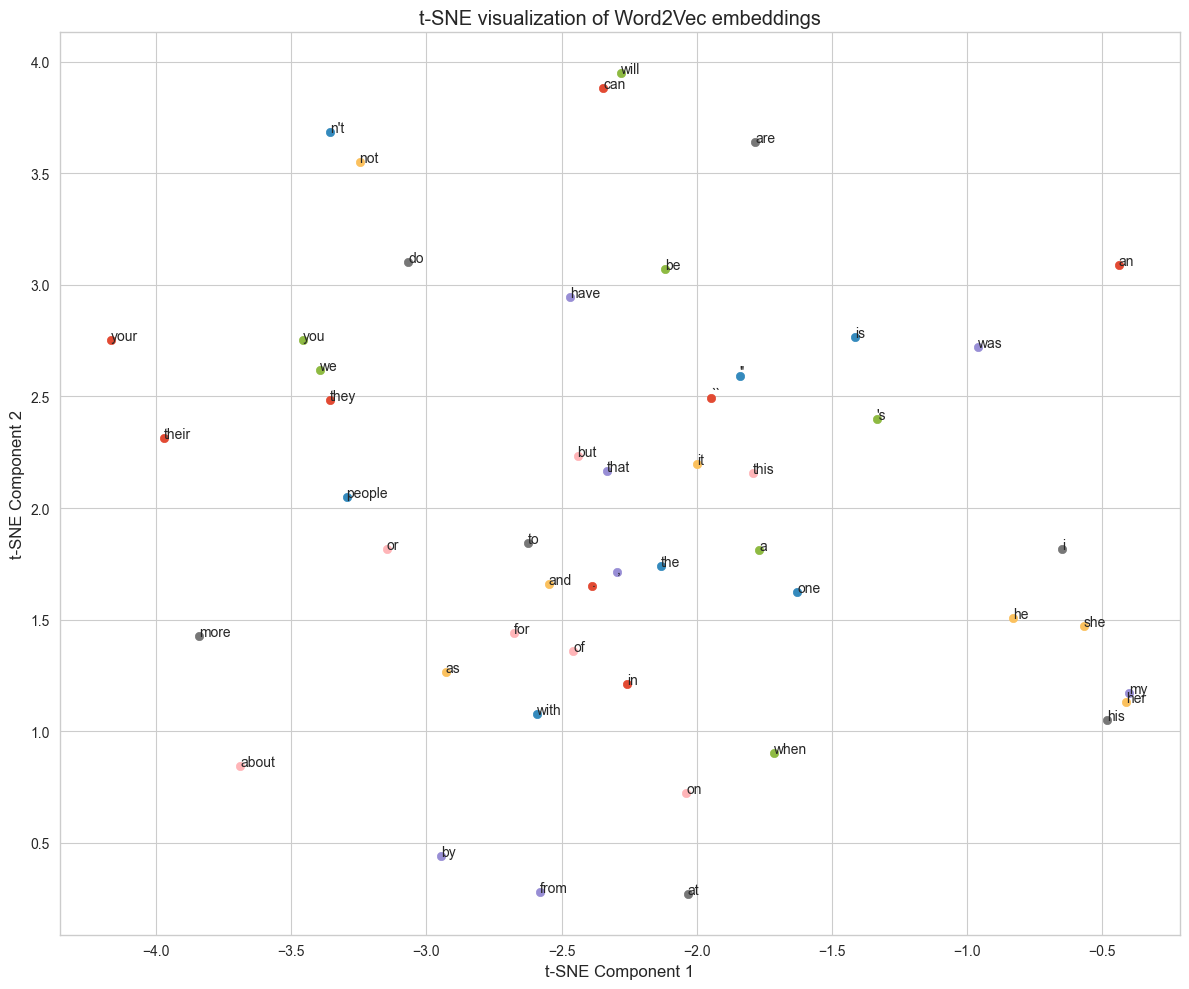

In [ ]:
# Install and import gensim for Word2Vec
try:
    import gensim
    from gensim.models import Word2Vec
except ImportError:
    !pip install gensim
    import gensim
    from gensim.models import Word2Vec

# Prepare sentences for Word2Vec
print("Preparing text for Word2Vec training...")
w2v_sample_size = min(20000, len(train_data))  # Adjust based on computational resources
w2v_sample = train_data.sample(w2v_sample_size, random_state=42)

# Tokenize each document into sentences, then words
sentences = []
for article in w2v_sample['article']:
    for sent in sent_tokenize(article):
        sentences.append(word_tokenize(sent.lower()))

# Train Word2Vec model
print("Training Word2Vec model...")
w2v_model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=5, workers=4, sg=1)

# Save the model
w2v_model.save("race_word2vec.model")

# Analyze word similarities
def explore_word_similarities(word, model, n=10):
    try:
        similar_words = model.wv.most_similar(word, topn=n)
        print(f"Words most similar to '{word}':")
        for similar_word, similarity in similar_words:
            print(f"  {similar_word}: {similarity:.4f}")
    except KeyError:
        print(f"'{word}' not in vocabulary")

# Test with some words
test_words = ['student', 'teacher', 'school', 'read', 'education']
for word in test_words:
    explore_word_similarities(word, w2v_model)
    print()

# Visualize word embeddings using t-SNE
def visualize_embeddings(model, words=None, n=100):
    """Visualize word embeddings using t-SNE"""
    # Get embeddings for visualization
    if words is None:
        if len(model.wv) < n:
            words = [word for word in model.wv.index_to_key]
        else:
            words = [model.wv.index_to_key[i] for i in range(n)]
    
    # Filter words to only include those in the model's vocabulary
    valid_words = [word for word in words if word in model.wv]
    
    # Get word vectors for valid words
    word_vectors = [model.wv[word] for word in valid_words]
    
    # Convert list of vectors to numpy array for t-SNE
    if len(word_vectors) == 0:
        print("No valid words found in the model's vocabulary.")
        return
        
    word_vectors_array = np.array(word_vectors)
    
    # Apply t-SNE
    print(f"Applying t-SNE to {len(valid_words)} word vectors...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, max(5, len(valid_words)-1)))
    embeddings_2d = tsne.fit_transform(word_vectors_array)
    
    # Visualize
    plt.figure(figsize=(12, 10))
    for i, word in enumerate(valid_words):
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1])
        plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]))
    
    plt.title('t-SNE visualization of Word2Vec embeddings')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.tight_layout()
    plt.show()

# Get the 50 most frequent words
all_words = [word for word_list in sentences for word in word_list]
word_counter = Counter(all_words)
most_common = [word for word, count in word_counter.most_common(50)]

# Visualize embeddings for most common words
visualize_embeddings(w2v_model, most_common)

## 2. Training Models

Now, let's build and train models for reading comprehension on the RACE dataset. The task is to predict the correct answer given a passage, a question, and multiple-choice options.

In [ ]:
# Prepare data for the multiple-choice question-answering task
def prepare_mcqa_data(df, sample_size=None):
    if sample_size is not None:
        df = df.sample(min(sample_size, len(df)), random_state=42)
    
    # Create features for each option
    features = []
    labels = []
    
    for _, row in df.iterrows():
        article = row['article']
        question = row['question']
        options = row['options']
        correct_option = ord(row['answer']) - ord('A')  # Convert A,B,C,D to 0,1,2,3
        
        for i, option in enumerate(options):
            # Combine article, question, and option as input feature
            combined = f"{article} [SEP] {question} [SEP] {option}"
            features.append(combined)
            # 1 if this is the correct answer, 0 otherwise
            labels.append(1 if i == correct_option else 0)
    
    return features, labels

# Prepare a small sample for initial model training
train_features, train_labels = prepare_mcqa_data(train_data, sample_size=5000)
val_features, val_labels = prepare_mcqa_data(val_data, sample_size=1000)

### 2.1 Simple Linear Model

Let's first try a simple linear model as a baseline.

In [ ]:
# TF-IDF vectorization for the linear model
tfidf_vec = TfidfVectorizer(max_features=10000, stop_words='english')
train_features_tfidf = tfidf_vec.fit_transform(train_features)
val_features_tfidf = tfidf_vec.transform(val_features)

# Train a logistic regression model
print("Training logistic regression model...")
lr_model = LogisticRegression(max_iter=1000, n_jobs=-1)
lr_model.fit(train_features_tfidf, train_labels)

# Evaluate on validation set
val_preds = lr_model.predict(val_features_tfidf)
val_probs = lr_model.predict_proba(val_features_tfidf)[:, 1]

print("Validation set performance:")
print(f"Accuracy: {accuracy_score(val_labels, val_preds):.4f}")
print(classification_report(val_labels, val_preds))

# To evaluate the actual multiple-choice accuracy, we need to group by question
def evaluate_mcqa(probs, labels, n_options=4):
    # Reshape probabilities and labels to group by question
    probs_grouped = np.array(probs).reshape(-1, n_options)
    labels_grouped = np.array(labels).reshape(-1, n_options)
    
    # For each question, predict the option with highest probability
    predictions = probs_grouped.argmax(axis=1)
    correct_answers = labels_grouped.argmax(axis=1)
    
    accuracy = np.mean(predictions == correct_answers)
    return accuracy

mcqa_accuracy = evaluate_mcqa(val_probs, val_labels)
print(f"\nMultiple-choice accuracy: {mcqa_accuracy:.4f}")

Training logistic regression model...
Validation set performance:
Accuracy: 0.7500
              precision    recall  f1-score   support

           0       0.75      1.00      0.86      3000
           1       0.00      0.00      0.00      1000

    accuracy                           0.75      4000
   macro avg       0.38      0.50      0.43      4000
weighted avg       0.56      0.75      0.64      4000


Multiple-choice accuracy: 0.2710
Validation set performance:
Accuracy: 0.7500
              precision    recall  f1-score   support

           0       0.75      1.00      0.86      3000
           1       0.00      0.00      0.00      1000

    accuracy                           0.75      4000
   macro avg       0.38      0.50      0.43      4000
weighted avg       0.56      0.75      0.64      4000


Multiple-choice accuracy: 0.2710


c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

### 2.2 Advanced Models with Transformers

Now, let's use a pre-trained transformer model for the reading comprehension task, following the structure of the example notebook.

In [ ]:
# Install necessary libraries for transformer models
try:
    import torch
    from transformers import AutoTokenizer, AutoModelForMultipleChoice, TrainingArguments, Trainer, AutoConfig
    from datasets import Dataset, DatasetDict
except ImportError:
    !pip install torch transformers datasets
    import torch
    from transformers import AutoTokenizer, AutoModelForMultipleChoice, TrainingArguments, Trainer, AutoConfig
    from datasets import Dataset, DatasetDict

# Check GPU status and enable it if available
import os
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    # Print GPU information
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU device name: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    
    # Create a test tensor on GPU
    test_tensor = torch.tensor([1, 2, 3], device=device)
    print(f"Test tensor device: {test_tensor.device}")
else:
    print("CUDA is not available. PyTorch is using CPU only.")

# Disable W&B reports
import os
os.environ["WANDB_DISABLED"] = "true"

# Load pre-trained model and tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Prepare data for transformer model specifically for multiple choice
def prepare_data_for_multiple_choice(df, sample_size=None):
    if sample_size is not None:
        df = df.sample(min(sample_size, len(df)), random_state=42)
    
    examples = []
    for _, row in df.iterrows():
        example = {
            'id': row['example_id'],
            'context': row['article'],
            'question': row['question'],
            'endings': row['options'],
            'label': ord(row['answer']) - ord('A')  # Convert A,B,C,D to 0,1,2,3
        }
        examples.append(example)
    
    return Dataset.from_list(examples)

# Create samples for transformer model training
transformer_train_sample_size = 500  # Reduced for quicker debugging
transformer_val_sample_size = 100
transformer_test_sample_size = 100

# Preprocess data for transformer model
print("Preparing data for transformer model...")
train_dataset = prepare_data_for_multiple_choice(train_data, sample_size=transformer_train_sample_size)
val_dataset = prepare_data_for_multiple_choice(val_data, sample_size=transformer_val_sample_size)
test_dataset = prepare_data_for_multiple_choice(test_data, sample_size=transformer_test_sample_size)

# Convert to expected format
def preprocess_function(examples):
    # The preprocessing function takes examples with keys 'context', 'question', 'endings', and 'label'
    contexts = examples['context']
    questions = examples['question']
    endings_lists = examples['endings']
    
    # Initialize lists to store the final outputs
    input_ids_list = []
    attention_mask_list = []
    token_type_ids_list = [] if 'token_type_ids' in tokenizer('a', 'b') else None
    
    # Process each example in batch
    for context, question, endings in zip(contexts, questions, endings_lists):
        example_input_ids = []
        example_attention_mask = []
        example_token_type_ids = [] if token_type_ids_list is not None else None
        
        # Process each ending/option
        for ending in endings:
            # Tokenize the context + question + ending pair
            tokenized = tokenizer(
                context,
                question + " " + ending,
                truncation=True,
                max_length=512,
                padding="max_length",
                return_tensors="pt"
            )
            
            # Add to the example lists
            example_input_ids.append(tokenized['input_ids'].squeeze().tolist())
            example_attention_mask.append(tokenized['attention_mask'].squeeze().tolist())
            if example_token_type_ids is not None:
                example_token_type_ids.append(tokenized['token_type_ids'].squeeze().tolist())
        
        # Add example data to batch lists
        input_ids_list.append(example_input_ids)
        attention_mask_list.append(example_attention_mask)
        if token_type_ids_list is not None:
            token_type_ids_list.append(example_token_type_ids)
    
    # Prepare the result dictionary
    result = {
        'input_ids': input_ids_list,
        'attention_mask': attention_mask_list,
    }
    
    # Add token_type_ids if present
    if token_type_ids_list is not None:
        result['token_type_ids'] = token_type_ids_list
    
    # Add labels
    if 'label' in examples:
        result['labels'] = examples['label']
    
    return result

# Process the datasets
train_processed = train_dataset.map(preprocess_function, batched=True, remove_columns=['id', 'context', 'question', 'endings'])
val_processed = val_dataset.map(preprocess_function, batched=True, remove_columns=['id', 'context', 'question', 'endings'])
test_processed = test_dataset.map(preprocess_function, batched=True, remove_columns=['id', 'context', 'question', 'endings'])

# Load model for multiple-choice tasks
config = AutoConfig.from_pretrained(model_name, num_labels=1)  # For multiple choice, num_labels should be 1
model = AutoModelForMultipleChoice.from_pretrained(model_name, config=config)
model = model.to(device)

# Set up training arguments
training_args = TrainingArguments(
    output_dir="./results/race_bert_model",
    learning_rate=5e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=1,  # Reduced for faster training
    weight_decay=0.01,
    report_to=None,
)

# Create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_processed,
    eval_dataset=val_processed,
)

# Train the model
print("Training the transformer model...")
trainer.train()

Using device: cuda
CUDA version: 12.1
GPU device name: NVIDIA GeForce RTX 4070 SUPER
Number of GPUs: 1
Test tensor device: cuda:0
Preparing data for transformer model...
Preparing data for transformer model...


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Training the transformer model...


Step,Training Loss


TrainOutput(global_step=250, training_loss=1.3750430908203124, metrics={'train_runtime': 51.5151, 'train_samples_per_second': 9.706, 'train_steps_per_second': 4.853, 'total_flos': 526217385984000.0, 'train_loss': 1.3750430908203124, 'epoch': 1.0})

In [ ]:
# CELL 3: Model Evaluation Section
# This cell can be run independently after training

# Evaluate the model
print("Evaluating the model...")
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

# Create a simple prediction function for new examples
def predict_answer(article, question, options):
    inputs = []
    for option in options:
        # Tokenize each context + question + option pair
        encoded = tokenizer(
            article,
            question + " " + option,
            truncation=True,
            max_length=512,
            padding="max_length",
            return_tensors="pt"
        )
        inputs.append({
            'input_ids': encoded['input_ids'].to(device),
            'attention_mask': encoded['attention_mask'].to(device),
            'token_type_ids': encoded.get('token_type_ids', None)
        })
    
    # Format the inputs for the model
    model_inputs = {
        'input_ids': torch.stack([inp['input_ids'] for inp in inputs]),
        'attention_mask': torch.stack([inp['attention_mask'] for inp in inputs])
    }
    
    if inputs[0]['token_type_ids'] is not None:
        model_inputs['token_type_ids'] = torch.stack([inp['token_type_ids'] for inp in inputs])
    
    # Pass through model and get prediction
    with torch.no_grad():
        outputs = model(**model_inputs)
        logits = outputs.logits
        predicted_idx = torch.argmax(logits).item()
    
    answer_letters = ["A", "B", "C", "D"]
    return answer_letters[predicted_idx]

# Test the model on a sample example
sample_idx = 0
sample = test_dataset[sample_idx]
predicted = predict_answer(
    sample["context"],
    sample["question"],
    sample["endings"]
)
correct = "ABCD"[sample["label"]]

print("\nSample prediction:")
print(f"Article (truncated): {sample['context'][:200]}...")
print(f"Question: {sample['question']}")
for i, option in enumerate(sample["endings"]):
    print(f"Option {chr(65+i)}: {option}")
print(f"Correct answer: {correct}")
print(f"Predicted answer: {predicted}")
print(f"Is correct: {predicted == correct}")

Evaluating the model...


Evaluation results: {'eval_loss': 1.3900054693222046, 'eval_runtime': 3.336, 'eval_samples_per_second': 29.976, 'eval_steps_per_second': 14.988, 'epoch': 1.0}


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

### 2.3 Zero-Shot and Few-Shot Learning with an LLM

Let's explore using a large language model for zero-shot and few-shot learning on the RACE dataset.

In [ ]:
# Install OpenAI package for LLM access
try:
    import openai
except ImportError:
    !pip install openai
    import openai

# Set up your OpenAI API key
# IMPORTANT: To use the OpenAI API, you need to:
# 1. Create an account at https://platform.openai.com/
# 2. Generate an API key
# 3. Set it below (or use environment variables for better security)

# Option 1: Set directly (not recommended for shared notebooks)
# openai.api_key = "your_api_key_here"  # Replace with your actual API key

# Option 2: Set from environment variable (more secure)
# import os
# openai.api_key = os.environ.get("OPENAI_API_KEY")

# Verify if API key is set
api_key_set = hasattr(openai, 'api_key') and openai.api_key is not None and openai.api_key != ""
print(f"OpenAI API key is {'set' if api_key_set else 'NOT set - LLM sections will not work'}")

# Define functions for zero-shot and few-shot learning
def zero_shot_mcqa(article, question, options, model="gpt-3.5-turbo"):
    prompt = f"""Read the following passage and answer the multiple-choice question.

Passage: {article}

Question: {question}

Options:
A. {options[0]}
B. {options[1]}
C. {options[2]}
D. {options[3]}

Answer with just the letter (A, B, C, or D) corresponding to the correct option.
Answer: """
    
    response = openai.ChatCompletion.create(
        model=model,
        messages=[
            {"role": "system", "content": "You are a reading comprehension assistant that answers multiple choice questions based on passages."},
            {"role": "user", "content": prompt}
        ],
        temperature=0,
        max_tokens=10
    )
    
    # Extract the answer
    answer = response.choices[0].message.content.strip()
    # Just take the first character if multiple chars were returned
    if answer and answer[0] in 'ABCD':
        return answer[0]
    return "X"  # Invalid response

def few_shot_mcqa(article, question, options, examples, model="gpt-3.5-turbo"):
    # Construct examples part of the prompt
    examples_text = """
Here are a few examples:
"""
    
    for i, ex in enumerate(examples):
        examples_text += f"""
Example {i+1}:
Passage: {ex['article']}

Question: {ex['question']}

Options:
A. {ex['options'][0]}
B. {ex['options'][1]}
C. {ex['options'][2]}
D. {ex['options'][3]}

Answer: {ex['answer']}
"""
    
    # Construct the actual query part
    query_text = f"""
Now, answer this new question:
Passage: {article}

Question: {question}

Options:
A. {options[0]}
B. {options[1]}
C. {options[2]}
D. {options[3]}

Answer with just the letter (A, B, C, or D) corresponding to the correct option.
Answer: """
    
    # Combine examples and query
    prompt = examples_text + query_text
    
    response = openai.ChatCompletion.create(
        model=model,
        messages=[
            {"role": "system", "content": "You are a reading comprehension assistant that answers multiple choice questions based on passages."},
            {"role": "user", "content": prompt}
        ],
        temperature=0,
        max_tokens=10
    )
    
    # Extract the answer
    answer = response.choices[0].message.content.strip()
    # Just take the first character if multiple chars were returned
    if answer and answer[0] in 'ABCD':
        return answer[0]
    return "X"  # Invalid response

## Conclusion and Next Steps

In this notebook, we have:

1. **Analyzed the RACE dataset** structure and characteristics
2. **Explored vocabulary** richness and diversity
3. **Clustered documents** to identify different types of passages
4. **Built a document search engine** for retrieving relevant passages
5. **Trained word embeddings** using Word2Vec
6. **Developed models** for multiple-choice reading comprehension:
   - A simple baseline using Logistic Regression
   - An advanced model using BERT
   - Explored LLM-based approaches (if API key was provided)

### Potential Extensions

Here are some ways to extend this work:

1. **Error analysis**: Examine the cases where models fail and identify patterns
2. **Model improvements**:
   - Try different transformer architectures (RoBERTa, DeBERTa, etc.)
   - Experiment with prompt engineering for LLMs
   - Implement ensemble methods combining multiple approaches
3. **Additional analyses**:
   - Analyze question types and model performance by question category
   - Explore passage complexity metrics and their correlation with model performance
   - Investigate potential biases in the dataset
4. **Deployment considerations**:
   - Model compression techniques for faster inference
   - API development for integrating the model into applications

### References

- [RACE dataset paper](https://www.aclweb.org/anthology/D17-1082/)
- [Hugging Face RACE dataset](https://huggingface.co/datasets/race)
- [Transformer models for multiple-choice](https://huggingface.co/docs/transformers/tasks/multiple_choice)